# 1. text-CNN

# 2. Bi-LSTM

# 3. LSTM

# 4. BERT

# 5. RoBERTa



In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam


import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel



from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\T2520843\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\T2520843\AppData\Roaming\Python\Python311\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
%pip install tf-keras

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [ ]:
%pip install pandas numpy scikit-learn nltk tensorflow torch transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install -U transformers accelerate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --force-reinstall

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp311-cp311-win_amd64.whl (2449.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp311-cp311-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp311-cp311-win_amd64.whl (4.1 MB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached https://download.pytorch.org/whl/typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached https://download.pytorch.org/whl/jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.3.5 which 

In [ ]:
df = pd.read_csv("hateXplain.csv")


In [ ]:
df.shape

(60444, 5)

Making all label same casing

In [ ]:
df["label"] = df["label"].str.lower()

In [ ]:
df.isnull().sum()

post_id             0
annotator_id        0
label               0
target          21192
post_tokens         0
dtype: int64

Replacing all null values with "other" word as they are imortant

In [ ]:
df["target"] = df["target"].fillna("Other")

In [ ]:
df.isnull().sum()

post_id         0
annotator_id    0
label           0
target          0
post_tokens     0
dtype: int64

Majority voting

Extracting unique texts based on post id and assigning with most common label

For target column, if all values are none, simply returns Nnone without counting.

In [ ]:
final_df = (
    df.groupby("post_id")
      .agg({
          "post_tokens": "first",
          "label": lambda x: x.value_counts().idxmax(),
          "target": lambda x: x.value_counts().idxmax() if not x.value_counts().empty else None
      })
      .reset_index(drop=True)
)

In [ ]:
final_df.shape

(20148, 3)

In [ ]:
final_df.head(15)

,post_tokens,label,target
0,jews are responsible for destroying my towns c...,hatespeech,Jewish
1,leftist mind control fails i think this overst...,normal,"Men, Other"
2,the scientific findings that advocates and the...,offensive,Homosexual
3,it why they behave like animals no matter wher...,hatespeech,African
4,why are people so offended by the word paki su...,offensive,Arab
5,sugar grove that out <number> sugar grove is n...,offensive,Caucasian
6,actually it the resist the dick movement it do...,offensive,Homosexual
7,right definitely not going back to the fag hag...,hatespeech,Homosexual
8,às vezes eu esqueço que meu nome tem origem sa...,offensive,Arab
9,oh look another peace gesture by the arab and ...,normal,Islam


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20148 entries, 0 to 20147
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   post_tokens  20148 non-null  object
 1   label        20148 non-null  object
 2   target       20148 non-null  object
dtypes: object(3)
memory usage: 472.3+ KB


Checked missing value

In [ ]:
final_df.isnull().sum()

post_tokens    0
label          0
target         0
dtype: int64

Dropping NULL values from target column

In [ ]:
final_df = final_df.dropna(subset=['target']).reset_index(drop=True)

In [ ]:
final_df.isnull().sum()

post_tokens    0
label          0
target         0
dtype: int64

In [ ]:
final_df.shape

(20148, 3)

Label encoding

In [ ]:
label_map = {
    "normal": 0,
    "offensive": 1,
    "hatespeech": 2
}

final_df = final_df[final_df["label"].isin(label_map.keys())]
final_df["label"] = final_df["label"].map(label_map)


In [ ]:
final_df.head()

,post_tokens,label,target
0,jews are responsible for destroying my towns c...,2,Jewish
1,leftist mind control fails i think this overst...,0,"Men, Other"
2,the scientific findings that advocates and the...,1,Homosexual
3,it why they behave like animals no matter wher...,2,African
4,why are people so offended by the word paki su...,1,Arab


Removed unwanted signs from texts if there is any

In [ ]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    filtered_words = []
    for word in words:
        if word not in stop_words:
            filtered_words.append(word)
    cleaned_text = " ".join(filtered_words)
    return text

In [ ]:
final_df["post_tokens"] = final_df["post_tokens"].apply(clean_text)


In [ ]:
final_df

,post_tokens,label,target
0,jews are responsible for destroying my towns c...,2,Jewish
1,leftist mind control fails i think this overst...,0,"Men, Other"
2,the scientific findings that advocates and the...,1,Homosexual
3,it why they behave like animals no matter wher...,2,African
4,why are people so offended by the word paki su...,1,Arab
...,...,...,...
20143,was macht der moslem wenn der zion gegen seine...,0,Other
20144,it is awful look at world demographics asians ...,2,Asian
20145,bill clinton is an evil creature um maybe slic...,1,Islam
20146,the uk has threatened to return radioactive wa...,1,"Minority, Refugee, Indian"


Train-Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df["post_tokens"],
    final_df["label"],
    test_size=0.2,
    random_state=42,
    stratify=final_df["label"]
)


# **Tokenization**

In [ ]:
max_vocab_size = 20000
max_sequence_length = 120#tried 100

In [ ]:
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

# **text-CNN model**

In [ ]:
from tensorflow.keras.regularizers import l2

cnn_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),#tried 0.005 and filter 32
    GlobalMaxPooling1D(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),#layer 16
    Dropout(0.7),#tried 0.5, 0.6
    Dense(3, activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),#tried 0.01, 0.0005, 0.003, 0.0003
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#tred without early stoppig
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#tried monitoring val_accuracy and patience -> 3, 5

history = cnn_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=20,#tried 10, 5, 15
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/20


C:\Users\T2520843\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4774 - loss: 1.2090 - val_accuracy: 0.5769 - val_loss: 0.9728
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5789 - loss: 0.9681 - val_accuracy: 0.6005 - val_loss: 0.8947
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6113 - loss: 0.9070 - val_accuracy: 0.6042 - val_loss: 0.8862
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6467 - loss: 0.8565 - val_accuracy: 0.6062 - val_loss: 0.8920
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6832 - loss: 0.8039 - val_accuracy: 0.6109 - val_loss: 0.9099
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7162 - loss: 0.7497 - val_accuracy: 0.6084 - val_loss: 0.9270
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7447 - loss: 0.7078 - val_accuracy: 0.6012 - val_loss: 0.9652
Epoch 8/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7708 - loss: 0.6778 - val_accuracy: 0.5965 - val_

Test Loss: 88.6235
Test Accuracy: 60.4218


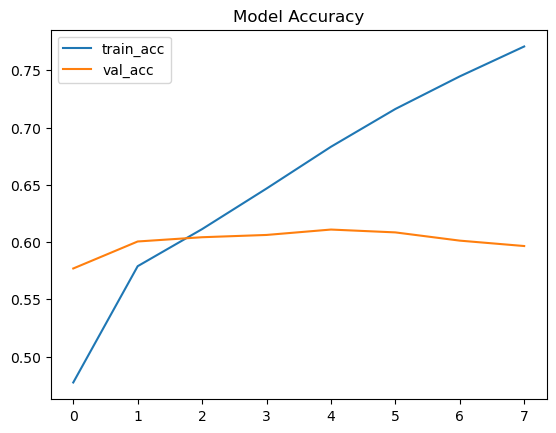

In [ ]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_pad, y_test, verbose=0)

print(f"Test Loss: {cnn_loss* 100 :.4f}")
print(f"Test Accuracy: {cnn_accuracy* 100:.4f}")


import matplotlib.pyplot as plt

plt.plot(cnn_model.history.history['accuracy'], label='train_acc')
plt.plot(cnn_model.history.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# **LSTM Model**

In [ ]:
EMBEDDING_DIM = 128

lstm_model = Sequential([
    Embedding(input_dim=max_vocab_size,output_dim=128,input_length=max_sequence_length),
    LSTM(units=128,return_sequences=False),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(3, activation="softmax")
])

lstm_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.005),#used 0.001
    metrics=["accuracy"]
)

history = lstm_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=15,
    batch_size=64
)


Epoch 1/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3991 - loss: 1.0921 - val_accuracy: 0.4047 - val_loss: 1.0877
Epoch 2/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.4046 - loss: 1.0881 - val_accuracy: 0.4047 - val_loss: 1.0873
Epoch 3/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.4046 - loss: 1.0875 - val_accuracy: 0.4047 - val_loss: 1.0871
Epoch 4/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.4046 - loss: 1.0874 - val_accuracy: 0.4047 - val_loss: 1.0870
Epoch 5/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.4046 - loss: 1.0874 - val_accuracy: 0.4047 - val_loss: 1.0872
Epoch 6/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.4046 - loss: 1.0877 - val_accuracy: 0.4047 - val_loss: 1.0871
Epoch 7/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.4046 - loss: 1.0873 - val_accuracy: 0.4047 - val_loss: 1.0872
Epoch 8/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.4046 - loss: 1.0874 - 

Evaluate LSTM model

Test Loss: 108.7272
Test Accuracy: 40.4715


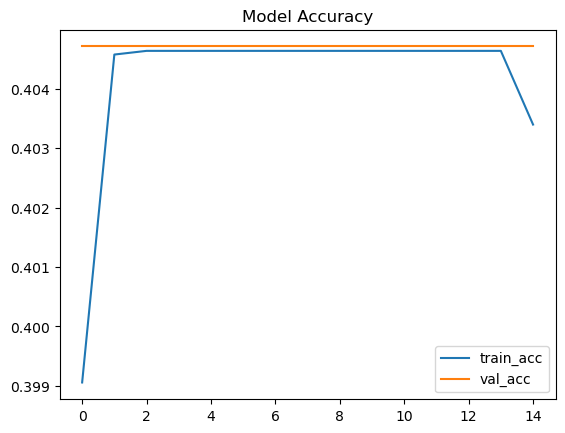

In [ ]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_pad, y_test, verbose=0)

print(f"Test Loss: {lstm_loss* 100 :.4f}")
print(f"Test Accuracy: {lstm_accuracy* 100:.4f}")


plt.plot(lstm_model.history.history['accuracy'], label='train_acc')
plt.plot(lstm_model.history.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# **Bidirectional LSTM Model**

In [ ]:
Bi_lstm_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=100),  # tried removing input_length
    SpatialDropout1D(0.3),
    Bidirectional(
        LSTM(48, dropout=0.3, recurrent_dropout=0.2, return_sequences=False)
    ),
    Dense(32, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

Bi_lstm_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = Bi_lstm_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=15,
    batch_size=64
)

Epoch 1/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.4631 - loss: 1.1658 - val_accuracy: 0.5804 - val_loss: 0.9771
Epoch 2/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.5965 - loss: 0.9171 - val_accuracy: 0.6017 - val_loss: 0.8768
Epoch 3/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.6532 - loss: 0.8072 - val_accuracy: 0.6074 - val_loss: 0.8598
Epoch 4/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.6948 - loss: 0.7333 - val_accuracy: 0.5983 - val_loss: 0.8654
Epoch 5/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.7337 - loss: 0.6783 - val_accuracy: 0.5928 - val_loss: 0.8910
Epoch 6/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.7624 - loss: 0.6237 - val_accuracy: 0.5995 - val_loss: 0.9306
Epoch 7/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - accuracy: 0.7855 - loss: 0.5830 - val_accuracy: 0.5940 - val_loss: 0.9496
Epoch 8/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.8072 - loss: 0.5321 

Evaluate Bi-lstm model

Test Loss: 128.5692
Test Accuracy: 56.6005


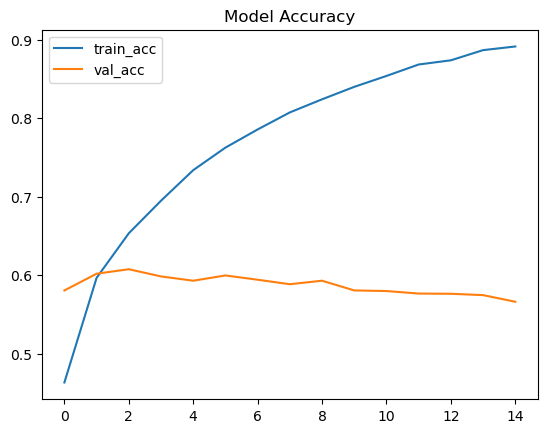

In [ ]:
Bi_lstm_loss, Bi_lstm_accuracy = Bi_lstm_model.evaluate(X_test_pad, y_test, verbose=0)

print(f"Test Loss: {Bi_lstm_loss* 100 :.4f}")
print(f"Test Accuracy: {Bi_lstm_accuracy* 100:.4f}")


plt.plot(Bi_lstm_model.history.history['accuracy'], label='train_acc')
plt.plot(Bi_lstm_model.history.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

Evaluate models - text-CNN, LSTM, Bi-LSTM

In [ ]:
print(f"--- Model Accuracy Comparison ---")
print(f"CNN Test Accuracy:  {cnn_accuracy:.4f}")
print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")
print(f"Bi_LSTM Test Accuracy: {Bi_lstm_accuracy:.4f}")

--- Model Accuracy Comparison ---
CNN Test Accuracy:  0.6042
LSTM Test Accuracy: 0.4047
Bi_LSTM Test Accuracy: 0.5660


# BERT Model

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

In [ ]:
# 1. Define the Dataset Class
# This converts our cleaned text and labels into the format BERT understands
class HateDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Extract features for the current index and convert to tensors
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # BERT expects the label key to be exactly 'labels'
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# 2. Tokenization
# We use the 'uncased' model because your preprocessing already converted text to lowercase
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer_bert(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer_bert(list(X_test), truncation=True, padding=True, max_length=128)

# Create the Dataset objects
train_dataset = HateDataset(train_encodings, y_train.tolist())
test_dataset = HateDataset(test_encodings, y_test.tolist())

In [ ]:
# 3. Model Definition
# We initialize the weights for 3 classes: Normal, Offensive, Hatespeech
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import transformers
print(transformers.__version__)

4.57.3


In [ ]:
import accelerate
print(accelerate.__version__)

1.12.0


In [ ]:
import torch
print(f"Is CUDA available? {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Is CUDA available? True
GPU Name: NVIDIA GeForce RTX 4070 Ti SUPER


In [ ]:
training_args_bert = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

In [ ]:


# Metric function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# 5. Trainer
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 6. Train and Evaluate
trainer_bert.train()
bert_eval_results = trainer_bert.evaluate()
bert_train_results = trainer_bert.evaluate(train_dataset)
bert_loss_results = trainer_bert.evaluate()

print(f"BERT Train Accuracy: {bert_train_results['eval_accuracy']:.4f}")
print(f"BERT Test Accuracy: {bert_eval_results['eval_accuracy']:.4f}")
print(f"BERT Loss Accuracy: {bert_loss_results['eval_accuracy']:.4f}")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.897500,0.754295,0.676427
2,0.705500,0.739322,0.684615
3,0.476400,0.828686,0.668238


BERT Train Accuracy: 0.8164
BERT Test Accuracy: 0.6846
BERT Loss Accuracy: 0.6846


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [ ]:
# 1. Tokenization
tokenizer_rob = RobertaTokenizer.from_pretrained('roberta-base')

train_enc_rob = tokenizer_rob(list(X_train), truncation=True, padding=True, max_length=128)
test_enc_rob = tokenizer_rob(list(X_test), truncation=True, padding=True, max_length=128)

train_dataset_rob = HateDataset(train_enc_rob, y_train.tolist())
test_dataset_rob = HateDataset(test_enc_rob, y_test.tolist())

In [ ]:
# 2. Model Definition
model_rob = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# 3. Training Arguments
training_args_rob = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none"
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# 4. Trainer
trainer_rob = Trainer(
    model=model_rob,
    args=training_args_rob,
    train_dataset=train_dataset_rob,
    eval_dataset=test_dataset_rob,
    compute_metrics=compute_metrics
)

# 5. Train and Evaluate
trainer_rob.train()
rob_eval_results = trainer_rob.evaluate()
rob_train_results = trainer_rob.evaluate(train_dataset_rob)
rob_loss_results = trainer_rob.evaluate()

print(f"RoBERTa Train Accuracy: {rob_train_results['eval_accuracy']:.4f}")
print(f"RoBERTa Test Accuracy: {rob_eval_results['eval_accuracy']:.4f}")
print(f"RoBERTa Loss Accuracy: {rob_loss_results['eval_accuracy']:.4f}")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.838500,0.764849,0.677419
2,0.692000,0.751691,0.678908
3,0.559700,0.791865,0.679404


RoBERTa Train Accuracy: 0.8358
RoBERTa Test Accuracy: 0.6794
RoBERTa Loss Accuracy: 0.6794


# **Evaluation function**

In [ ]:
#label_map = {"normal": 0,"offensive": 1,"hatespeech": 2}

target_names = list(label_map.keys())

In [ ]:
from sklearn.metrics import classification_report, accuracy_score


def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n{model_name} Accuracy: {accuracy:.4f}\n")
    print(classification_report(
        y_test,
        y_pred,
        target_names = target_names,
        digits=4
    ))

In [ ]:
bert_y_predictions = trainer_bert.predict(test_dataset)
bert_y_pred = np.argmax(bert_y_predictions.predictions, axis=1)
bert_y_true = bert_y_predictions.label_ids

In [ ]:
rob_y_predictions = trainer_rob.predict(test_dataset_rob)
rob_y_pred = np.argmax(rob_y_predictions.predictions, axis=1)
rob_y_true = rob_y_predictions.label_ids

In [ ]:
print("---------------------------------------------")
print("\ntext-CNN Classification Report:\n")
evaluate_model(cnn_model, X_test_pad, y_test, model_name="TextCNN")
print("---------------------------------------------")
print("\nLSTM Classification Report:\n")
evaluate_model(lstm_model, X_test_pad, y_test, model_name="LSTM")
print("---------------------------------------------")
print("\nBi-LSTM Classification Report:\n")
evaluate_model(Bi_lstm_model, X_test_pad, y_test, model_name="Bi-LSTM")
print("---------------------------------------------")
print("\nBERT Classification Report:\n")
print(classification_report(bert_y_true,bert_y_pred,target_names=target_names,digits=4))
print("---------------------------------------------")
print("\nRoBERTa Classification Report:\n")
print(classification_report(rob_y_true,rob_y_pred,target_names=target_names,digits=4))

---------------------------------------------

text-CNN Classification Report:

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step

TextCNN Accuracy: 0.6042

              precision    recall  f1-score   support

      normal     0.5743    0.8817    0.6955      1631
   offensive     0.4615    0.0208    0.0399      1152
  hatespeech     0.6601    0.7803    0.7152      1247

    accuracy                         0.6042      4030
   macro avg     0.5653    0.5609    0.4835      4030
weighted avg     0.5686    0.6042    0.5142      4030

---------------------------------------------

LSTM Classification Report:

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

LSTM Accuracy: 0.4047

              precision    recall  f1-score   support

      normal     0.4047    1.0000    0.5762      1631
   offensive     0.0000    0.0000    0.0000      1152
  hatespeech     0.0000    0.0000    0.0000      1247

    accuracy                         0.4047      4030
   macro avg     0.1349    0.3333    0.1921      4030
w

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step

Bi-LSTM Accuracy: 0.5660

              precision    recall  f1-score   support

      normal     0.6439    0.5941    0.6180      1631
   offensive     0.3868    0.4835    0.4298      1152
  hatespeech     0.6959    0.6055    0.6475      1247

    accuracy                         0.5660      4030
   macro avg     0.5755    0.5610    0.5651      4030
weighted avg     0.5865    0.5660    0.5733      4030

---------------------------------------------

BERT Classification Report:

              precision    recall  f1-score   support

      normal     0.7194    0.7357    0.7275      1631
   offensive     0.5645    0.5243    0.5437      1152
  hatespeech     0.7392    0.7658    0.7523      1247

    accuracy                         0.6846      4030
   macro avg     0.6744    0.6753    0.6745      4030
weighted avg     0.6812    0.6846    0.6826      4030

---------------------------------------------

RoBERTa Classification Report:

              

In [ ]:
# Extract BERT validation accuracy - get only end-of-epoch evaluations
bert_history = trainer_bert.state.log_history
# Filter for entries with eval_accuracy and take only those with eval_loss (end of epoch marker)
bert_evals = [(i, log['eval_accuracy']) for i, log in enumerate(bert_history) if 'eval_accuracy' in log and 'eval_loss' in log]
bert_val_acc = [acc for _, acc in bert_evals[:3]]  # Take only first 3 (for 3 epochs)

In [ ]:
# Extract RoBERTa validation accuracy - get only end-of-epoch evaluations
roberta_history = trainer_rob.state.log_history
roberta_evals = [(i, log['eval_accuracy']) for i, log in enumerate(roberta_history) if 'eval_accuracy' in log and 'eval_loss' in log]
roberta_val_acc = [acc for _, acc in roberta_evals[:3]]  # Take only first 3 (for 3 epochs)


In [ ]:
# Get final validation accuracies
cnn_final = cnn_model.history.history['val_accuracy'][-1]
lstm_final = lstm_model.history.history['val_accuracy'][-1]
bilstm_final = Bi_lstm_model.history.history['val_accuracy'][-1]
bert_final = bert_val_acc[-1]
roberta_final = roberta_val_acc[-1]

In [ ]:
print(" " * 20 + "ACTUAL VALIDATION ACCURACY")
print("=" * 75)
print(f"{'Model':<15} {'Epochs':<10} {'Final Val Acc':<25} {'Status':<15}")
print("-" * 75)
print(f"{'TextCNN':<15} {len(cnn_model.history.history['val_accuracy']):<10} {cnn_final:.4f} ({cnn_final*100:.2f}%){'      ⭐ BEST' if cnn_final == best_accuracy else ''}")
print(f"{'LSTM':<15} {len(lstm_model.history.history['val_accuracy']):<10} {lstm_final:.4f} ({lstm_final*100:.2f}%){'  ❌ FAILED' if lstm_final < 0.5 else ''}{'      ⭐ BEST' if lstm_final == best_accuracy else ''}")
print(f"{'Bi-LSTM':<15} {len(Bi_lstm_model.history.history['val_accuracy']):<10} {bilstm_final:.4f} ({bilstm_final*100:.2f}%){'      ⭐ BEST' if bilstm_final == best_accuracy else ''}")
print(f"{'BERT':<15} {len(bert_val_acc):<10} {bert_final:.4f} ({bert_final*100:.2f}%){'      ⭐ BEST' if bert_final == best_accuracy else ''}")
print(f"{'RoBERTa':<15} {len(roberta_val_acc):<10} {roberta_final:.4f} ({roberta_final*100:.2f}%){'      ⭐ BEST' if roberta_final == best_accuracy else ''}")
print("=" * 75)

                    ACTUAL VALIDATION ACCURACY
Model           Epochs     Final Val Acc             Status         
---------------------------------------------------------------------------
TextCNN         8          0.5965 (59.65%)
LSTM            15         0.4047 (40.47%)  ❌ FAILED
Bi-LSTM         15         0.5660 (56.60%)
BERT            3          0.6682 (66.82%)
RoBERTa         3          0.6794 (67.94%)      ⭐ BEST


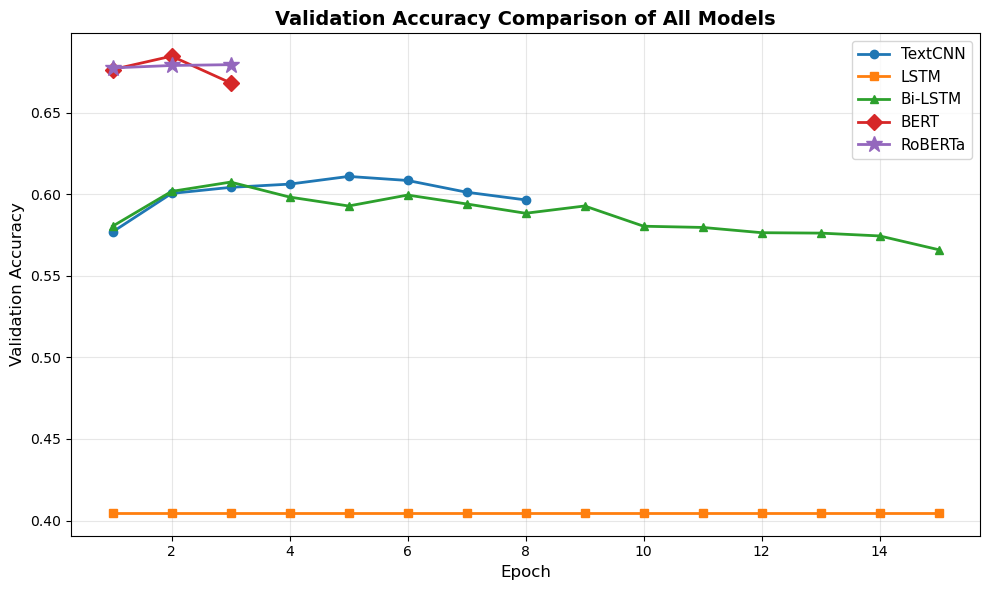

In [ ]:
# Plot all 5 models' validation accuracy in one graph with correct epoch alignment
plt.figure(figsize=(10, 6))

# Plot each model with its actual epoch range
plt.plot(range(1, len(cnn_model.history.history['val_accuracy'])+1),
         cnn_model.history.history['val_accuracy'],
         label='TextCNN', marker='o', linewidth=2)

plt.plot(range(1, len(lstm_model.history.history['val_accuracy'])+1),
         lstm_model.history.history['val_accuracy'],
         label='LSTM', marker='s', linewidth=2)

plt.plot(range(1, len(Bi_lstm_model.history.history['val_accuracy'])+1),
         Bi_lstm_model.history.history['val_accuracy'],
         label='Bi-LSTM', marker='^', linewidth=2)

plt.plot(range(1, len(bert_val_acc)+1),
         bert_val_acc,
         label='BERT', marker='D', linewidth=2, markersize=8)

plt.plot(range(1, len(roberta_val_acc)+1),
         roberta_val_acc,
         label='RoBERTa', marker='*', markersize=12, linewidth=2)

plt.title('Validation Accuracy Comparison of All Models', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()